# 等离子体电子声波：Two-kappa Electrons Model

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

## 模型
### 1D等离子体：双kappa运动电子+静止均匀分布离子
- 初始分布函数
$$ f(x,v,0) = \left( f_s + f_f  \right) (1+d \cos kx) $$
$$ f_s = \frac{n_s}{\sqrt{2\pi T (\kappa_s-3/2)}} \frac{\Gamma(\kappa_s)}{\Gamma(\kappa_s-1/2)} \left( 1+\frac{1}{\kappa_s-3/2} \frac{v^2}{2T} \right)^{-\kappa_s} $$
$$ f_f = \frac{n_f}{\sqrt{2\pi T (\kappa_f-3/2)}} \frac{\Gamma(\kappa_f)}{\Gamma(\kappa_f-1/2)} \left( 1+\frac{1}{\kappa_f-3/2} \frac{v^2}{2T} \right)^{-\kappa_f} $$
                          
- 色散关系
$$ 1 + \frac{2 \omega_s^2}{k^2 \theta_s^2} \left[ 1 - \frac{1}{2\kappa_s} +\xi_s Z_{\kappa_s}(\xi_s) \right] + \frac{2 \omega_f^2}{k^2 \theta_f^2} \left[ 1 - \frac{1}{2 \kappa_f} +\xi_f Z_{\kappa_f}(\xi_f) \right] = 0 $$
其中$\xi_\sigma = \frac{\omega}{k \theta_\sigma}$，$\theta_\sigma = \sqrt{\frac{2\kappa_\sigma-3}{\kappa_\sigma} \frac{T}{m}}$，
$$ Z_{\kappa_\sigma}(\xi) = \frac{\Gamma(\kappa_\sigma+1)}{\sqrt{\pi}\kappa_\sigma^{3/2} \Gamma(\kappa_\sigma-1/2)} \int_{-\infty}^{+\infty} \frac{(1+s^2/\kappa_\sigma)^{-\kappa_\sigma-1}}{s-\xi} ds$$
上述色散关系将允许两支波，一支类似于fast electrons的Langmuir波（LW）；另一支类似于slow electrons的Acoustic波（KW，由两组分不同$\kappa$导致）

- 让KW展现出来的关键在于
    - 排除热电子LW，$\gamma_{KW} < \gamma_{LW}^{hot}$
    - KW本身不能过阻尼，$\gamma_{KW} \le \omega_r/(2\pi)$，满足此条件可获得存在较长时间的KW

## 数值理论分析

In [272]:
def fk(v):
    r_s = ( 1 + v**2/(kappa_s-3/2)/(2*T) )**(-kappa_s)
    r_f = ( 1 + v**2/(kappa_f-3/2)/(2*T) )**(-kappa_f)
    A_s = n_s/np.sqrt(2*np.pi*T*(kappa_s-3/2)) * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
    A_f = n_f/np.sqrt(2*np.pi*T*(kappa_f-3/2)) * sp.gamma(kappa_f)/sp.gamma(kappa_f-1/2)
    
    return A_s*r_s+A_f*r_f

# exact PDR
def dispersion_function(zeta,kappa):
    fac = 1j * (kappa+0.5) * (kappa-0.5) / kappa**1.5 / (kappa+1)
    z = 0.5*(1+1j*zeta/np.sqrt(kappa))
    hyp = sp.hyp2f1(1,2*kappa+2,kappa+2,z)
    return fac*hyp

def PDR_2KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    zeta_f = wc / k /v_f
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + 1 / k**2 / l_f**2 * ( 1 + zeta_f*plasmapy.dispersion.plasma_dispersion_func(zeta_f) )
    return [r.real,r.imag]

def PrintParas():
    paras_table = PrettyTable(['T='+str(T),'n','kappa','wp','theta','lambda_D'])
    paras_table.add_row(['s',n_s,kappa_s,round(wp_s,4),round(v_s,4),round(l_s,4)])
    paras_table.add_row(['f',n_f,'-',round(wp_f,4),round(v_f,4),round(l_f,4)])
    print(paras_table)
    
def SetParas():
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    v_s = np.sqrt((2-3/kappa_s)*T/m)
    v_f = np.sqrt(2*T/m)
    return n_f,l_s,l_f,wp_s,wp_f,v_s,v_f

<!-- ### PDR中的KW分支和LW分支 -->

In [365]:
# 等离子体基本参数
n = 1
q = 1
m = 1
T = 1

n_s = 0.5
kappa_s = 1.505

n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
PrintParas()

+-----+-----+-------+--------+--------+----------+
| T=1 |  n  | kappa |   wp   | theta  | lambda_D |
+-----+-----+-------+--------+--------+----------+
|  s  | 0.5 | 1.505 | 0.7071 | 0.0815 |  1.4142  |
|  f  | 0.5 |   -   | 0.7071 | 1.4142 |  1.4142  |
+-----+-----+-------+--------+--------+----------+


In [366]:
wr_kw_guess = 0.0153
wi_kw_guess = -0.270
wr_lw_guess = 1.002
wi_lw_guess = 0.0

In [367]:
k_list = np.linspace(0.1,1.5,num=200)
# 搜索a=0时解方程初值
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw_guess,wi_kw_guess],method='hybr')
s2=op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_lw_guess,wi_lw_guess],method='hybr')
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s2.success,s2.x)
wr_kw_guess_int = s0.x[0]
wi_kw_guess_int = s0.x[1]
wr_lw_guess_int = s2.x[0]
wi_lw_guess_int = s2.x[1]

k =  0.1
True [ 0.07351357 -0.04186058]
True [ 1.00802763e+00 -1.08702321e-04]


In [368]:
wr_kw_guess = wr_kw_guess_int
wi_kw_guess = wi_kw_guess_int
wr_lw_guess = wr_lw_guess_int
wi_lw_guess = wi_lw_guess_int

wr_kw_list = np.array([])
wi_kw_list = np.array([])
wr_lw_list = np.array([])
wi_lw_list = np.array([])

for k_each in tqdm(k_list,position=0,leave=True):
    s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
    if s_kw.success==True:
        wr_kw_guess = round(s_kw.x[0],10)
        wi_kw_guess = round(s_kw.x[1],10)
        wr_kw_list = np.append(wr_kw_list,s_kw.x[0])
        wi_kw_list = np.append(wi_kw_list,s_kw.x[1])
    else:
        wr_kw_list = np.append(wr_kw_list,np.nan)
        wi_kw_list = np.append(wi_kw_list,np.nan)
        
    s_lw = op.root(lambda w:PDR_2KE(w,k_each),[wr_lw_guess,wi_lw_guess],method='hybr')
    if s_lw.success==True:
        wr_lw_guess = round(s_lw.x[0],6)
        wi_lw_guess = round(s_lw.x[1],6)
        wr_lw_list = np.append(wr_lw_list,s_lw.x[0])
        wi_lw_list = np.append(wi_lw_list,s_lw.x[1])
    else:
        wr_lw_list = np.append(wr_lw_list,np.nan)
        wi_lw_list = np.append(wi_lw_list,np.nan)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1058.02it/s]


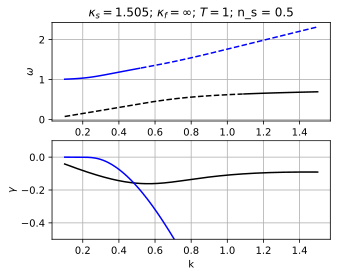

In [369]:
fig = plt.figure(figsize=(5,4))

ax1 = plt.subplot(211)
# ax1.set_xlabel('k')
ax2.set_xticklabels([])
ax1.set_ylabel(r'$\omega$')
ax1.grid()
plt.title(r"$\kappa_s = $"+str(kappa_s)+"; $\kappa_f = \infty$"+"; $T = $"+str(T)+"; n_s = "+str(n_s))
ax2 = plt.subplot(212)
ax2.set_xlabel('k')
ax2.set_ylabel(r'$\gamma$')
ax2.grid()
b_kw = wi_kw_list/abs(wr_kw_list/2/np.pi)
b_lw = wi_lw_list/abs(wr_lw_list/2/np.pi)
# ax3 = plt.subplot(212)
# ax3.axhline(-1,linestyle='--')
# ax3.set_xlabel('k')
# ax3.set_ylabel(r'$\gamma/\frac{\omega}{2\pi}$')
# ax3.grid()

ax1.plot(k_list[b_kw>-1],wr_kw_list[b_kw>-1],'-',color='black')
ax1.plot(k_list[b_lw>-1],wr_lw_list[b_lw>-1],'-',color='blue')
ax1.plot(k_list[b_kw<=-1],wr_kw_list[b_kw<=-1],'--',color='black')
ax1.plot(k_list[b_lw<=-1],wr_lw_list[b_lw<=-1],'--',color='blue')
# ax1.axvspan(k_list[b_kw>-1][0],k_list[b_kw>-1][-1],color='black',alpha=0.2)
# ax1.axvspan(k_list[b_lw>-1][0],k_list[b_lw>-1][-1],color='blue',alpha=0.2)

ax2.plot(k_list,wi_kw_list,color='black')
ax2.plot(k_list,wi_lw_list,color='blue')
ax2.set_ylim(-0.5,0.1)

# ax3.plot(k_list,b_kw,color='red')
# ax3.plot(k_list,b_lw,color='blue')

plt.show()

### KW波色散关系随T变化规律

In [346]:
k_list = np.linspace(0.1,3.0,num=100)
T_list = np.linspace(1,10,num=100)

In [347]:
n_s=0.5
T = T_list[0]
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
# k_list = k_list/l_f
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw_guess_int,wi_kw_guess_int])
print('k = ',k_list[0])
print(s0.success,s0.x)

k =  0.1
True [ 0.07219835 -0.03984015]


In [348]:
wr_kw_guess = wr_kw_guess_int
wi_kw_guess = wi_kw_guess_int

wr_kw_mat = []
wi_kw_mat = []
b_mat = []

for T_each in tqdm(T_list,position=0,leave=True):
    T = T_each
    n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()

    wr_kw_list = []
    wi_kw_list = []
    
    for k_each in k_list:
        s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
        if s_kw.success==True:
            wr_kw = round(s_kw.x[0],6)
            wi_kw = round(s_kw.x[1],6)
            wr_kw_guess = wr_kw
            wi_kw_guess = wi_kw
            if wr_kw not in wr_kw_list:
                wr_kw_list.append(wr_kw)
                wi_kw_list.append(wi_kw)

        b_list = np.array(wi_kw_list)/abs(np.array(wr_kw_list)/2/np.pi)
        
    wr_kw_guess = wr_kw_list[0]
    wi_kw_guess = wi_kw_list[0]
    
    wr_kw_mat.append(wr_kw_list)
    wi_kw_mat.append(wi_kw_list)
    b_mat.append(b_list)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.46it/s]


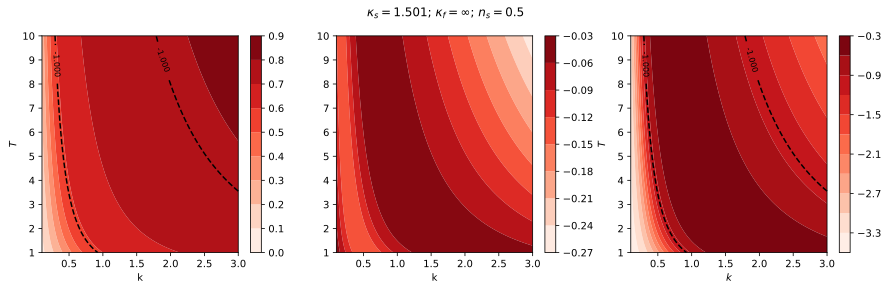

In [349]:
k_grid,T_grid=np.meshgrid(k_list,T_list)
fig = plt.figure(figsize=(15,4))

ax1 = plt.subplot(131)
cm1 = ax1.contourf(k_grid,T_grid,wr_kw_mat,cmap='Reds')
ax1.set_xlabel('k')
ax1.set_ylabel(r'$T$')
cf1 = ax1.contour(k_grid,T_grid,b_mat,levels=[-1,0],colors='Black')
ax1.clabel(cf1,inline=True,fontsize=8)
# ax1.grid()
fig.colorbar(cm1)

ax2 = plt.subplot(132)
cm2 = ax2.contourf(k_grid,T_grid,wi_kw_mat,cmap='Reds')
ax2.set_xlabel('k')
# ax2.grid()
fig.colorbar(cm2)

ax3 = plt.subplot(133)
cm3 = ax3.contourf(k_grid,T_grid,b_mat,levels=10,cmap='Reds')
fig.colorbar(cm3)
cf3 = ax3.contour(k_grid,T_grid,b_mat,levels=[-1,0],colors='Black')
ax3.clabel(cf3,inline=True,fontsize=8)
ax3.set_xlabel('$k$')
ax3.set_ylabel('$T$')
# ax3.grid()

plt.suptitle(r"$\kappa_s = $"+str(kappa_s)+"; $\kappa_f = \infty$"+"; $n_s = $"+str(n_s))
plt.show()

### KW波色散关系随$n_s$变化规律

In [370]:
k_list = np.linspace(0.1,3.0,num=100)
n_s_list = np.linspace(0.1,0.75,num=100)

In [371]:
kappa_s = 1.505
n_s=n_s_list[0]
# n_s = 0.1
T = 1
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.03,-0.1])
print('k = ',k_list[0])
print(s0.success,s0.x)

k =  0.1
True [ 0.03414756 -0.01136002]


In [372]:
wr_kw_guess = s0.x[0] 
wi_kw_guess = s0.x[1]

wr_kw_mat = []
wi_kw_mat = []
b_mat = []

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()

    wr_kw_list = []
    wi_kw_list = []
    
    for k_each in k_list:
        s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
        if s_kw.success==True:
            wr_kw = round(s_kw.x[0],6)
            wi_kw = round(s_kw.x[1],6)
            wr_kw_guess = wr_kw
            wi_kw_guess = wi_kw
            if wr_kw not in wr_kw_list:
                wr_kw_list.append(wr_kw)
                wi_kw_list.append(wi_kw)

        b_list = np.array(wi_kw_list)/abs(np.array(wr_kw_list)/2/np.pi)
        
    wr_kw_guess = wr_kw_list[0]
    wi_kw_guess = wi_kw_list[0]
    
    wr_kw_mat.append(wr_kw_list)
    wi_kw_mat.append(wi_kw_list)
    b_mat.append(b_list)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.36it/s]


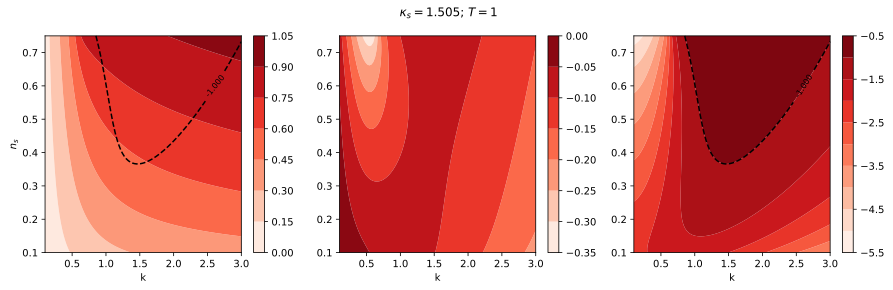

In [373]:
k_grid,n_s_grid=np.meshgrid(k_list,n_s_list)
fig = plt.figure(figsize=(15,4))

ax1 = plt.subplot(131)
cm1 = ax1.contourf(k_grid,n_s_grid,wr_kw_mat,cmap='Reds')
ax1.set_xlabel('k')
ax1.set_ylabel('$n_s$')
cf1 = ax1.contour(k_grid,n_s_grid,b_mat,levels=[-1,0],colors='Black')
ax1.clabel(cf1,inline=True,fontsize=8)
# ax1.grid()
fig.colorbar(cm1)

ax2 = plt.subplot(132)
cm2 = ax2.contourf(k_grid,n_s_grid,wi_kw_mat,cmap='Reds')
ax2.set_xlabel('k')
# ax2.grid()
fig.colorbar(cm2)

ax3 = plt.subplot(133)
cm3 = ax3.contourf(k_grid,n_s_grid,b_mat,levels=10,cmap='Reds')
fig.colorbar(cm3)
cf3 = ax3.contour(k_grid,n_s_grid,b_mat,levels=[-1,0],colors='Black')
ax3.clabel(cf3,inline=True,fontsize=8)
ax3.set_xlabel('k')
# ax3.grid()

plt.suptitle(r"$\kappa_s = $"+str(kappa_s)+"; $T = $"+str(T))
plt.show()

### KW波存在条件：$\gamma < \omega/(2\pi)$
令$b = \gamma/\frac{\omega}{2\pi}$

#### $b_{min}(n_s,T)$图

In [235]:
k_list = np.linspace(0.1,3.0,num=50)
n_s_list = np.linspace(0.1,0.7,num=50)
T_list = np.linspace(1,10,num=50)

In [236]:
n_s=n_s_list[0]
T = T_list[0]
kappa_s = 1.505
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.03,-0.1])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[1.06,-0.0001])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)

k =  0.1
True [ 0.03414756 -0.01136002]
True [ 1.01378426e+00 -2.11255496e-05]


In [237]:
b_min_mat = []
wr_kw_guess = s0.x[0]
wi_kw_guess = s0.x[1]
wr_k0 = 0.0
wi_k0 = 0.0
wr_T0 = 0.0
wi_T0 = 0.0

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    b_min_list = []
    for T_each in T_list:
        T = T_each
        n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
        
        b_list=np.array([])
        for k_each in k_list:
            s = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
            if s.success==True:
                wr_kw_guess = round(s.x[0],6)
                wi_kw_guess = round(s.x[1],6)
                b_list=np.append(b_list,(s.x[1]/abs(s.x[0]/2/np.pi)))
            if k_each == k_list[0]:
                wr_k0 = s.x[0]
                wi_k0 = s.x[1]
                if T_each == T_list[0]:
                    wr_T0 = wr_k0
                    wi_T0 = wi_k0
        b_min_list.append(np.amax(b_list))
        wr_kw_guess = wr_k0
        wi_kw_guess = wi_k0
    b_min_mat.append(b_min_list)
    wr_kw_guess = wr_T0
    wi_kw_guess = wi_T0

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:31<00:00,  1.84s/it]


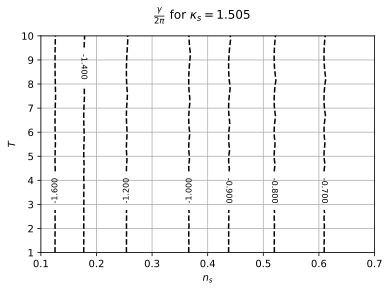

In [252]:
T_grid,n_s_grid=np.meshgrid(T_list,n_s_list)
cf = plt.contour(n_s_grid,T_grid,b_min_mat,levels=[-1.6,-1.4,-1.2,-1,-0.9,-0.8,-0.7,0],colors='Black')
plt.clabel(cf,inline=True,fontsize=8)
plt.suptitle(r'$\frac{\gamma}{2\pi}$' + r' for $\kappa_s=$'+str(kappa_s))
plt.xlabel('$n_s$')
plt.ylabel('$T$')
plt.grid()
plt.show()

#### $b_{min}(n_s,\kappa_s)$图

In [298]:
k_list = np.linspace(0.1,5.0,num=50)
n_s_list = np.linspace(0.1,0.9,num=100)
kappa_s_list = np.linspace(1.501,1.55,num=100)

In [299]:
n_s=n_s_list[0]
T = 100
kappa_s = kappa_s_list[0]
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.072,-0.016])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[1.127,-1.202])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)

k =  0.1
True [ 0.24251156 -0.03197864]
True [ 2.00199305 -0.88262337]


In [300]:
b_min_mat = []
wr_kw_guess = 0.072
wi_kw_guess = -0.016
wr_k0 = 0.0
wi_k0 = 0.0
wr_kappa0 = 0.0
wi_kappa0 = 0.0

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    b_min_list = []
    for kappa_s_each in kappa_s_list:
        kappa_s = kappa_s_each
        n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
        b_list=np.array([])
        for k_each in k_list:
            s = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
            if s.success==True:
                wr_kw_guess = round(s.x[0],6)
                wi_kw_guess = round(s.x[1],6)
                b_list=np.append(b_list,(s.x[1]/abs(s.x[0]/2/np.pi)))
            if k_each == k_list[0]:
                wr_k0 = s.x[0]
                wi_k0 = s.x[1]
                if kappa_s_each == kappa_s_list[0]:
                    wr_kappa0 = wr_k0
                    wi_kappa0 = wi_k0
        b_min_list.append(np.amax(b_list))
        wr_kw_guess = wr_k0
        wi_kw_guess = wi_k0
    b_min_mat.append(b_min_list)
    wr_kw_guess = wr_kappa0
    wi_kw_guess = wi_kappa0

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:28<00:00,  3.29s/it]


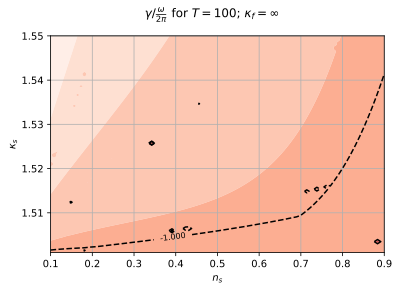

In [301]:
kappa_s_grid,n_s_grid=np.meshgrid(kappa_s_list,n_s_list)
cm = plt.contourf(n_s_grid,kappa_s_grid,b_min_mat,levels=15,cmap='Reds')
cf = plt.contour(n_s_grid,kappa_s_grid,b_min_mat,levels=[-1,0],colors='Black')
plt.clabel(cf,inline=True,fontsize=8)
plt.suptitle(r'$\gamma/\frac{\omega}{2\pi}$' + r' for $T=$'+str(T)+"; $\kappa_f = \infty$")
plt.xlabel('$n_s$')
plt.ylabel('$\kappa_s$')
plt.grid()
plt.show()

## 模拟验证

### 模拟参数设定

In [488]:
T = 5
n_s = 0.79
kappa_s = 1.51
kappa_f = 100
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
PrintParas()

k = 0.6
L = 2*np.pi/k

vmax = 20 # 速度最大值
nx = 401
nv = 1001
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
dt = 0.01
max_steps  = 10000
data_steps = 2000
data_num = int(max_steps/data_steps)+1
d = 0.001

path = '../data/'
print(data_num)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

+-----+---------------------+-------+--------+--------+----------+
| T=5 |          n          | kappa |   wp   | theta  | lambda_D |
+-----+---------------------+-------+--------+--------+----------+
|  s  |         0.79        |  1.51 | 0.8888 | 0.2573 |  2.5158  |
|  f  | 0.20999999999999996 |  100  | 0.4583 | 3.1385 |  4.8795  |
+-----+---------------------+-------+--------+--------+----------+
6
limited time= 261.79938779914943
real time =  100.0


In [489]:
s_lw_sim=op.root(lambda w:PDR_2KE(w,k),[1.5,-1.3])
s_kw_sim=op.root(lambda w:PDR_2KE(w,k),[1.23,-0.12])
print(s_lw_sim.success,s_lw_sim.x)
print(s_kw_sim.success,s_kw_sim.x)

True [ 1.82389666 -2.25757106]
True [ 0.9135871  -0.10444096]


### KW条件检验
- $\gamma_{KW} < \gamma_{LW}^{hot}$

In [490]:
print('r_kw = ',round(abs(s_kw_sim.x[1]),6))
print('r_lw = ',round(abs(s_lw_sim.x[1]),6))

r_kw =  0.104441
r_lw =  2.257571


- $k\lambda_h \le 1$

In [491]:
print('k*l_D_f = ',round(k*l_f,6))

k*l_D_f =  2.9277


- $\gamma_{KW} < \omega_r/(2\pi)$

In [492]:
print('r_eaw   = ',round(abs(s_kw_sim.x[1]),6))
print('wr/2/pi = ',round(s_kw_sim.x[0]/2/np.pi,6))

r_eaw   =  0.104441
wr/2/pi =  0.145402


### 模拟结果

In [495]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

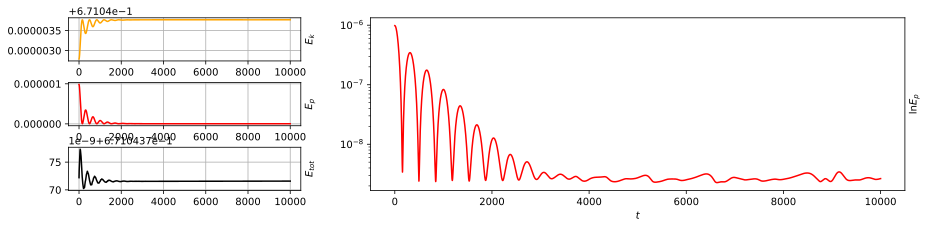

In [496]:
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.grid()
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 3), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.grid()
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.grid()
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 3), (0, 1),colspan=2, rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.3)
plt.xlabel(r'$t$')
plt.show()

In [497]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [498]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L

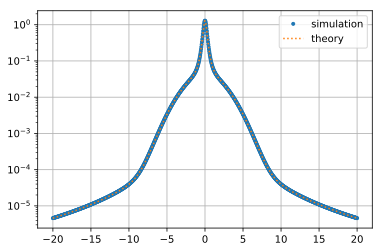

In [499]:
plt.plot(v,fv0,'.',label='simulation')
plt.plot(v,fk(v),':',label='theory')
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()

$$ E_p \propto E^2 \propto \left( e^{i \omega_r t+\omega_i t} \right)^2 = e^{i 2\omega_r t+2\omega_i t} $$

In [500]:
def PlotWaveFreq(t,y,refFreq,refFreq2):
    n = t.size
    y_k = fftpack.fft(y)
    x_k = fftpack.fftfreq(len(y_k),dt)
    y_k_abs = np.abs(y_k)
    y_k_phi = np.angle(y_k)

    plt.figure(figsize=(10,3))
    
    ax2 = plt.subplot()
    k_plot_scale=n//30
    ax2.plot(np.pi*x_k[1:k_plot_scale],2*y_k_abs[1:k_plot_scale]/n,color='black',lw=2)
    ax2.axvline(refFreq,color='red',ls='--',label=r'$\omega_{KW}$ = '+str(round(refFreq,6)))
    ax2.axvline(refFreq2,color='orange',ls='--',label=r'$\omega_{KW}$ = '+str(round(refFreq2,6)))
    ax2.set_title('freq-wave')
    ax2.set_xlabel(r'$\omega$')
    ax2.set_ylabel('A')
    ax2.grid()
    ax2.legend()
    
    plt.show()
    
def line(p, x):
    k, b = p
    return k*x+b

def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r

def period(x):
    return (x[1]-x[0])/1.

def errPercent(a, b):
    r = abs((a-b)/b)
    return r

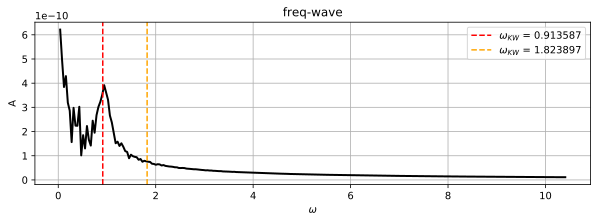

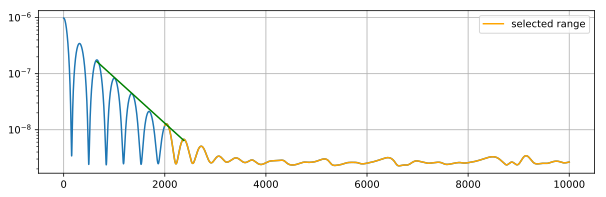

In [501]:
start = 2000
end = 10000

indexes, _ = scipy.signal.find_peaks(dataep, distance=5)
xep = indexes[2:8:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
wr_sim = 2*np.pi/per_sim/2
wi_sim = para[0]/dt/2

PlotWaveFreq(t[start:end],dataep[start:end],s_kw_sim.x[0],s_lw_sim.x[0])
fig = plt.figure(figsize=(10,3))
plt.plot(t,dataep)
plt.plot(t[start:end],dataep[start:end],color='orange',label='selected range')
plt.plot(xep,np.exp(line(para,xep)), '-',color='green')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [502]:
wr0_err = abs(wr_sim-s_kw_sim.x[0])/s_kw_sim.x[0]*100
wr1_err = abs(wr_sim-s_lw_sim.x[0])/s_lw_sim.x[0]*100
wi0_err = abs(abs(wi_sim)-abs(s_kw_sim.x[1]))/abs(s_kw_sim.x[1])*100
wi1_err = abs(abs(wi_sim)-abs(s_lw_sim.x[1]))/abs(s_lw_sim.x[1])*100
com_table = PrettyTable(['EAW: k='+str(k),'wr','wi'])
com_table.add_row(['Theory0',round(s_kw_sim.x[0],6),round(abs(s_kw_sim.x[1]),6)])
com_table.add_row(['Theory1',round(s_lw_sim.x[0],6),round(abs(s_lw_sim.x[1]),6)])
com_table.add_row(['Simulation',round(wr_sim,6),round(abs(wi_sim),6)])
com_table.add_row(['Error0(%)',round(wr0_err,6),round(abs(wi0_err),6)])
com_table.add_row(['Error1(%)',round(wr1_err,6),round(abs(wi1_err),6)])
print(com_table)

+------------+-----------+-----------+
| EAW: k=0.6 |     wr    |     wi    |
+------------+-----------+-----------+
|  Theory0   |  0.913587 |  0.104441 |
|  Theory1   |  1.823897 |  2.257571 |
| Simulation |  0.913254 |  0.094229 |
| Error0(%)  |  0.036496 |  9.777735 |
| Error1(%)  | 49.928431 | 95.826089 |
+------------+-----------+-----------+
